In [83]:
import os
import tqdm
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split

In [84]:
plt.rcParams["figure.dpi"] = 120
plot_size = 3

In [85]:
variant = "moons"
# variant = "blobs"
# variant = "moons-unclean"

In [100]:
viz_samples = 100000
viz_dotsize = 125

dotsize = 10

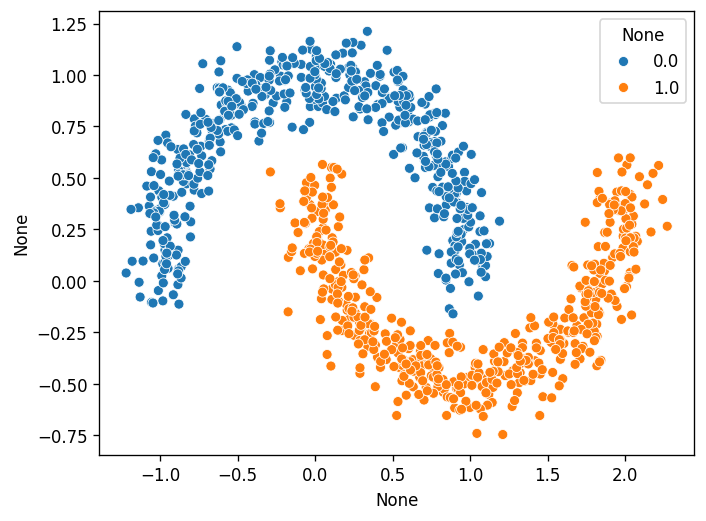

In [87]:
if variant == "moons":
    X, y = make_moons(n_samples=1000, noise=0.1, random_state=42)
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.reshape(-1))

elif variant == "blobs":
    X, y = make_blobs(
        n_samples=1000, centers=[[-2, -2], [2, 2]], n_features=2, random_state=42
    )
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.reshape(-1))

elif variant == "moons-unclean":
    X, y = make_moons(n_samples=1000, noise=0.5, random_state=42)
    X = torch.Tensor(X)
    y = torch.Tensor(y).reshape(-1, 1)
    train_x, test_x, train_y, test_y = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    sns.scatterplot(x=X.T[0], y=X.T[1], hue=y.reshape(-1))

In [88]:
dim = 5.5

viz_x = np.linspace((-dim, -dim), (dim, dim), viz_samples)
viz_x = torch.tensor(
    np.random.default_rng().permuted(viz_x.T, axis=1).T, dtype=torch.float32
)

In [89]:
def get_grad_norm(model, loss_fn, x, y):
    model.zero_grad()
    loss = loss_fn(model(x), y)
    loss.backward()

    grads = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())

    return torch.norm(torch.cat(grads))

In [90]:
def get_grad_norm_grid(model, loss_fn, samples, permute=lambda x: x):
    viz_grad = []

    for x in samples:
        viz_grad.append(
            get_grad_norm(
                model, loss_fn, x.reshape(1, -1), permute(model(x.reshape(1, -1)).round())
            )
        )

    return torch.tensor(viz_grad)

In [91]:
def draw_grad_norm_grid(
    test_x,
    test_y,
    viz_x,
    grad_norm_grid,
    ax,
    title=None,
    palette="rocket_r",
    cbar=False,
    class_labels=True,
):
    legend = None if not class_labels else "full"
    sns.scatterplot(
        x=viz_x.T[0],
        y=viz_x.T[1],
        hue=grad_norm_grid,
        marker=".",
        edgecolor=None,
        legend=None,
        palette=palette,
        linewidth=0,
        s=viz_dotsize,
        alpha=0.25,
        ax=ax,
    )
    sns.scatterplot(
        x=test_x.T[0],
        y=test_x.T[1],
        hue=test_y,
        edgecolor="black",
        legend=legend,
        s=dotsize,
        ax=ax,
    )
    if legend:
        ax.get_legend().set_title(None)
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    if cbar:
        norm = plt.Normalize(grad_norm_grid.min(), grad_norm_grid.max())
        sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
        sm.set_array([])
        ax.figure.colorbar(sm, ax=ax)

    ax.set_title(title)

In [92]:
class Model(nn.Module):
    def __init__(self, hidden_size=1028):
        super().__init__()
        self.layer_1 = nn.Linear(2, hidden_size)
        self.layer_2 = nn.Linear(hidden_size, 1)
        self.act = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.layer_1(x))
        x = self.sigmoid(self.layer_2(x))
        return x

In [93]:
model = Model()
epochs = 100

checkpoints = [1, 2, 3, 5, 10, 50, 100]
grad_norm_grids = {}
grad_flip_norm_grids = {}

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

grad_norm_grids[0] = get_grad_norm_grid(model, loss_fn, viz_x)
grad_flip_norm_grids[0] = get_grad_norm_grid(model, loss_fn, viz_x, lambda x: 1 - x)

for n in tqdm.tqdm(range(epochs)):
    for i in range(len(train_x)):
        y_hat = model(train_x[i].reshape(1, -1))
        loss = loss_fn(y_hat, train_y[i].reshape(-1, 1))
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    if n + 1 in checkpoints:
        grad_norm_grids[n + 1] = get_grad_norm_grid(model, loss_fn, viz_x)
        grad_flip_norm_grids[n + 1] = get_grad_norm_grid(model, loss_fn, viz_x, lambda x: 1 - x)

model.eval()

with torch.no_grad():
    y_hat = model(test_x)

with torch.no_grad():
    viz_y_hat = model(viz_x)

100%|██████████| 100/100 [05:35<00:00,  3.36s/it]


In [94]:
print(grad_norm_grids[0])

tensor([9.5943, 9.1260, 8.9471,  ..., 9.2602, 9.2073, 9.1929])


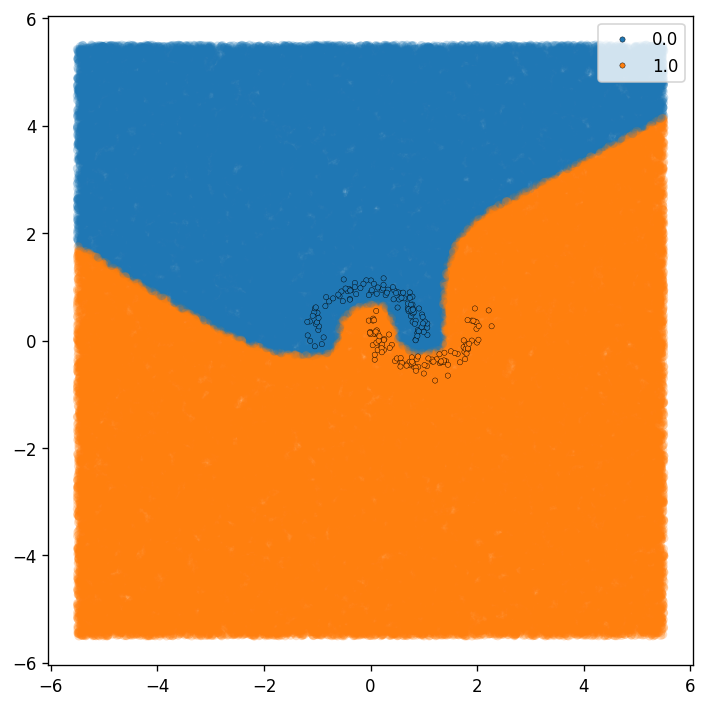

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(2*plot_size, 2*plot_size))

draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    viz_y_hat.T[0].round(),
    ax,
    palette="tab10",
)

plt.tight_layout()

os.makedirs(f"figures/{variant}", exist_ok=True)    
plt.savefig(f"figures/{variant}/decision_surface.png", transparent=True)

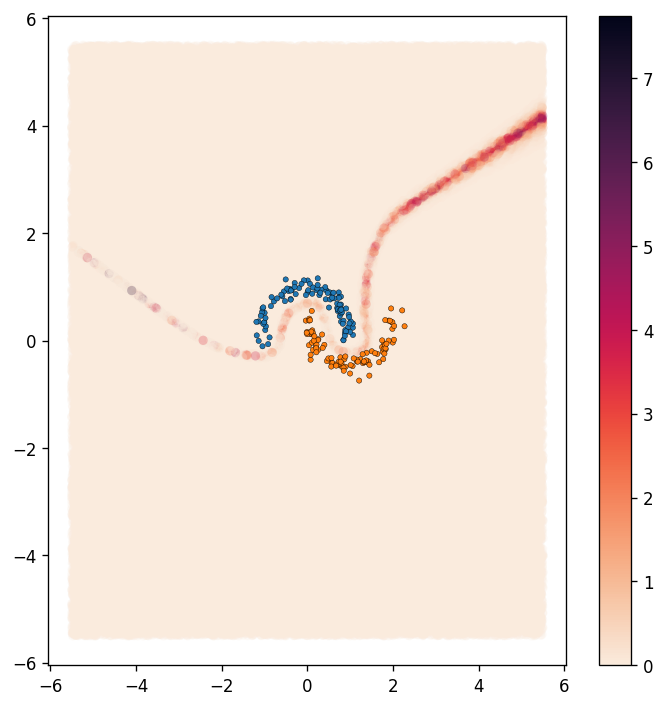

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(2*plot_size, 2*plot_size))

draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    grad_norm_grids[100],
    ax,
    cbar=True,
    class_labels=False
)

plt.tight_layout()

os.makedirs(f"figures/{variant}", exist_ok=True)    
plt.savefig(f"figures/{variant}/gradient_uncertainty.png", transparent=True)

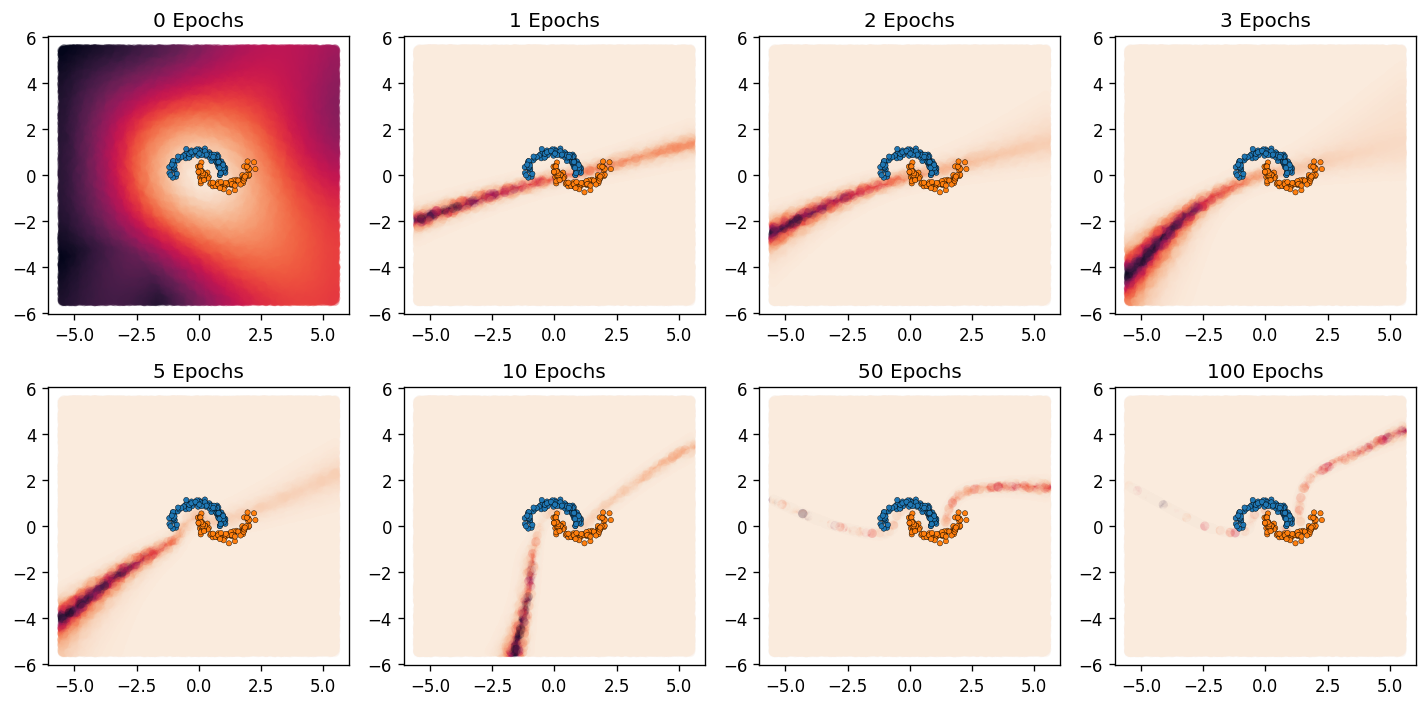

In [144]:
plt_width = 4
plt_height = len(grad_norm_grids) // plt_width

fig, axs = plt.subplots(
    plt_height, plt_width, figsize=(plt_width * plot_size, plt_height * plot_size)
)
for i, checkpoint in enumerate(grad_norm_grids):
    draw_grad_norm_grid(
        test_x,
        y_hat.T[0].round(),
        viz_x,
        grad_norm_grids[checkpoint],
        axs[i//plt_width][i%plt_width],
        title=f"{checkpoint} Epochs",
        # cbar=True if i%plt_width == plt_width-1 else False,
        class_labels=False,
    )

plt.tight_layout()

os.makedirs(f"figures/{variant}", exist_ok=True)    
plt.savefig(f"figures/{variant}/gradient_uncertainty_epochs.png", transparent=True)

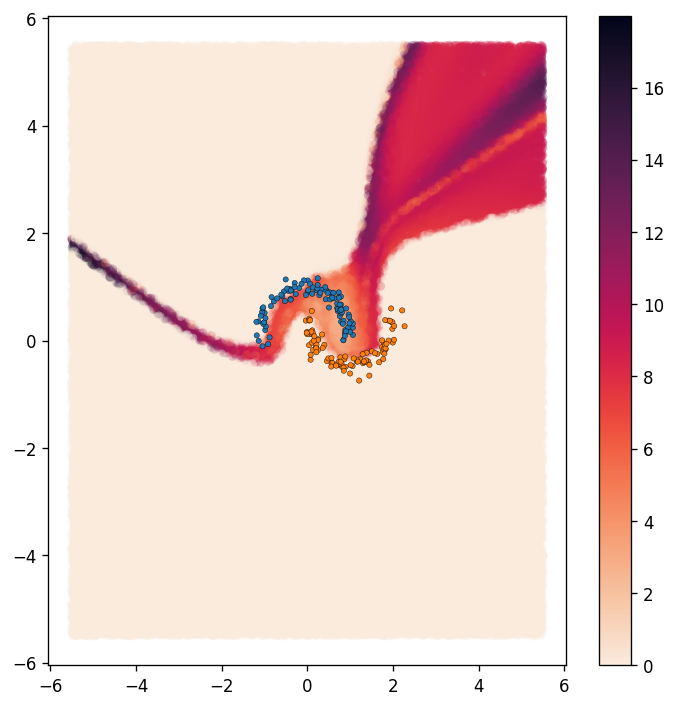

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(2*plot_size, 2*plot_size))

draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    grad_flip_norm_grids[100],
    ax,
    cbar=True,
    class_labels=False
)

plt.tight_layout()

os.makedirs(f"figures/{variant}", exist_ok=True)    
plt.savefig(f"figures/{variant}/gradient_flipped_uncertainty.png", transparent=True)

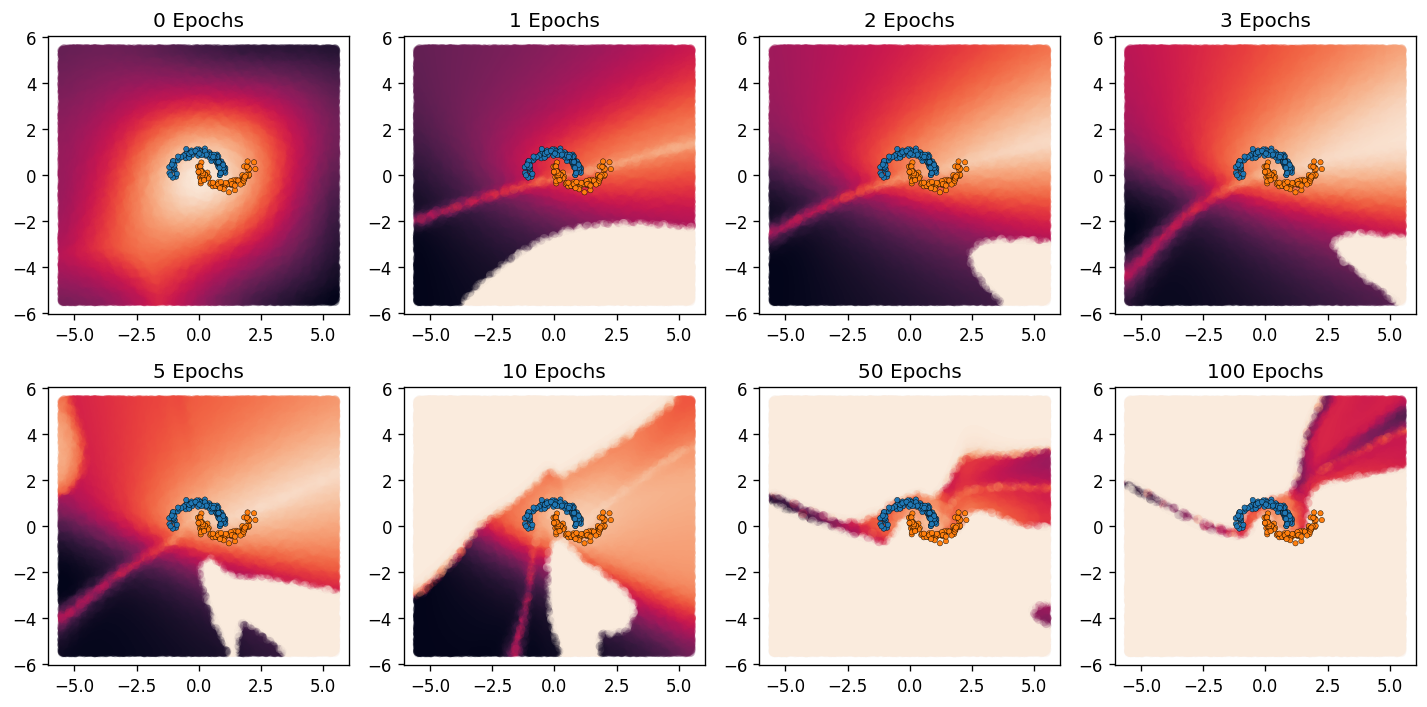

In [146]:
fig, axs = plt.subplots(
    plt_height, plt_width, figsize=(plt_width * plot_size, plt_height * plot_size)
)
for i, checkpoint in enumerate(grad_flip_norm_grids):
    draw_grad_norm_grid(
        test_x,
        y_hat.T[0].round(),
        viz_x,
        grad_flip_norm_grids[checkpoint],
        axs[i//plt_width][i%plt_width],
        title=f"{checkpoint} Epochs",
        # cbar=True if i%plt_width == plt_width-1 else False,
        class_labels=False,
    )

plt.tight_layout()

os.makedirs(f"figures/{variant}", exist_ok=True)    
plt.savefig(f"figures/{variant}/gradient_flipped_uncertainty_epochs.png", transparent=True)

In [147]:
viz_loss = []
viz_loss_flip = []

viz_grad = []

for x in tqdm.tqdm(viz_x):
    viz_x_y_hat = model(x.reshape(1, -1))
    loss = loss_fn(viz_x_y_hat, viz_x_y_hat.round())
    loss_flip = loss_fn(viz_x_y_hat, 1 - viz_x_y_hat.round())

    viz_loss.append(loss)
    viz_loss_flip.append(loss_flip)

viz_loss = torch.tensor(viz_loss)
viz_loss_flip = torch.tensor(viz_loss_flip)

100%|██████████| 100000/100000 [00:07<00:00, 12582.03it/s]


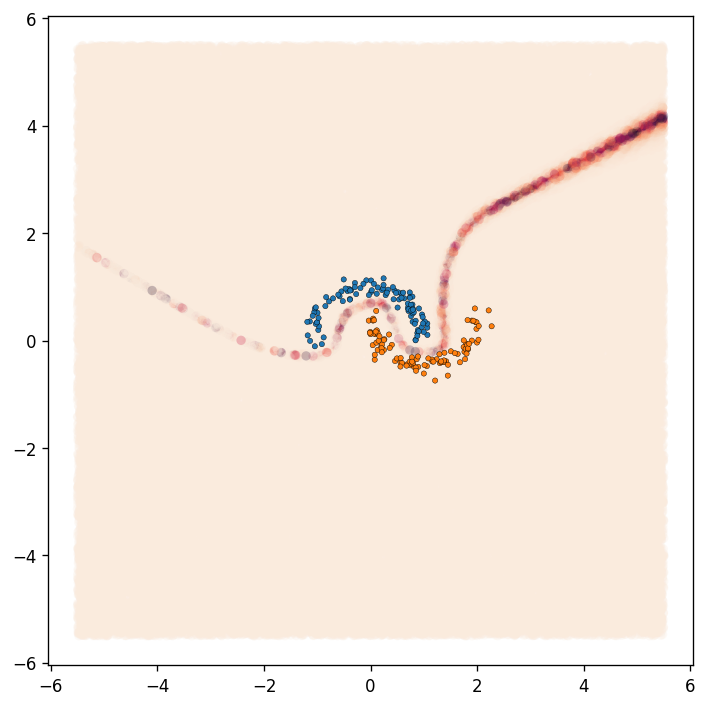

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(2*plot_size, 2*plot_size))

draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    viz_loss,
    ax,
    class_labels=False,
)

plt.tight_layout()

os.makedirs(f"figures/{variant}", exist_ok=True)    
plt.savefig(f"figures/{variant}/loss_uncertainty.png", transparent=True)

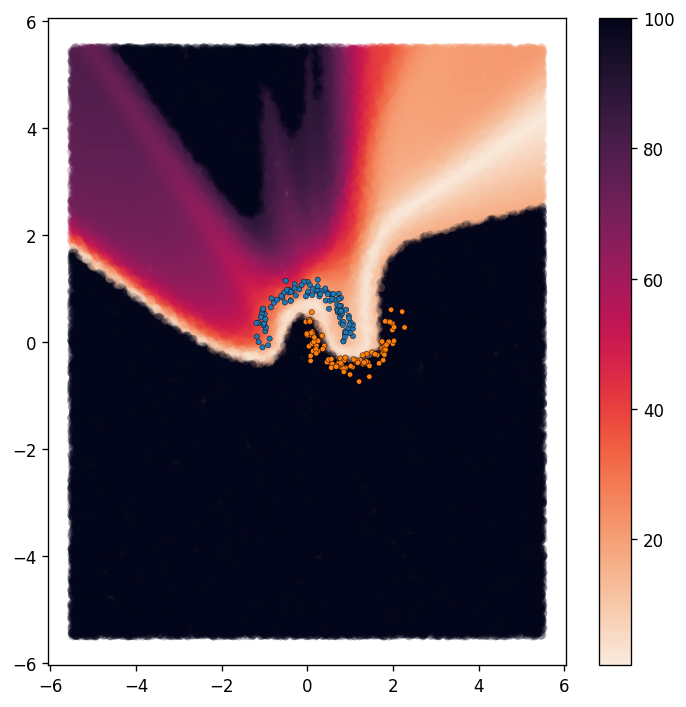

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(2*plot_size, 2*plot_size))

draw_grad_norm_grid(
    test_x,
    y_hat.T[0].round(),
    viz_x,
    viz_loss_flip,
    ax,
    cbar=True,
    class_labels=False,
)

plt.tight_layout()

os.makedirs(f"figures/{variant}", exist_ok=True)    
plt.savefig(f"figures/{variant}/loss_flipped_uncertainty.png", transparent=True)